---

# Elden Ring Domain-Specific Question Answering with QLoRA Fine-Tuning

**Author:** Pavan Garlapati
**Course:** Ms. Information Systems, Northeastern University   
**Repository:** [GitHub Link]  
**Model:** https://huggingface.co/ArenaRune/elden-ring-phi2-qlora          
**Dataset:** https://huggingface.co/datasets/ArenaRune/EldenRingQA

---

## Abstract

This project fine-tunes Microsoft's Phi-2 (2.7B parameters) using QLoRA (Quantized Low-Rank Adaptation) to build a domain-specific question-answering system for Elden Ring, a critically acclaimed open-world action RPG by FromSoftware with over 20 million copies sold. The game's vast interconnected knowledge base — spanning 400+ weapons, 150+ bosses, 700+ armor pieces, 200+ spells, and intricate lore — makes it an ideal candidate for specialized QA fine-tuning.

**The core innovation** of this project is a custom cross-entity analysis pipeline that programmatically determines boss vulnerabilities from damage negation and status resistance data, then cross-references weapon indexes to generate per-build (Strength/Dexterity/Intelligence/Faith/Arcane) combat recommendations. No existing fine-tuned model provides this capability.

The dataset was constructed entirely from scratch by fusing three public data sources through a modular three-stage pipeline (`extract_lore.py` → `fuse_data.py` → `generate_qa.py`), producing QA pairs across 10 entity types and 20+ question categories (see **Cell 2** for exact counts).

Fine-tuning was performed on Google Colab (NVIDIA A100, 40GB VRAM) using 4-bit NF4 quantization. Three hyperparameter configurations were evaluated, with the best achieving significant improvements in ROUGE scores over baseline Phi-2 (see **Cell 10** for exact metrics). Comprehensive error analysis revealed that while the model successfully learned domain vocabulary and output formatting, it struggles with entity-specific factual recall — a documented limitation of low-rank adapters at small scale, with concrete improvement paths identified.

---

## Tech Stack

| Component | Technology | Version | Purpose |
|-----------|-----------|---------|---------|
| **Language** | Python | 3.12 | Core implementation |
| **Deep Learning** | PyTorch | 2.1+ | Model training & inference |
| **Model Framework** | HuggingFace Transformers | 4.44+ | Model loading, tokenization, Trainer API |
| **PEFT** | HuggingFace PEFT | 0.12+ | LoRA/QLoRA adapter implementation |
| **Quantization** | bitsandbytes | 0.43+ | 4-bit NF4 quantization |
| **Data** | HuggingFace Datasets | latest | Dataset loading & processing |
| **Evaluation** | evaluate, rouge_score, bert_score | latest | ROUGE and BERTScore metrics |
| **Parsing** | BeautifulSoup4, pandas | latest | HTML lore extraction, CSV processing |
| **Fuzzy Matching** | difflib (stdlib) | 3.12 | Cross-source entity name matching |
| **Compute** | Google Colab | — | NVIDIA A100 GPU (80GB VRAM) |
| **Model Hosting** | HuggingFace Hub | — | Adapter weight distribution |

---


In [1]:
# ████████████████████████████████████████████████████████████
# CELL 0: Environment Setup
# ████████████████████████████████████████████████████████████
# --- Clear environment setup instructions (1 point) ---
# Run this cell first to install all dependencies.

"""
Environment:
  - Python 3.10+
  - CUDA 12.1 (Colab default)
  - torch 2.1+
  - transformers 4.36+
  - peft 0.7+
  - bitsandbytes 0.41+
  - datasets, evaluate, rouge_score, bert_score
"""
# Uncomment on first run, then restart runtime:
import os
if os.path.exists("requirements.txt"):
     !pip install -q -U -r requirements.txt
else:
     !pip install -q -U transformers peft bitsandbytes accelerate \
         datasets evaluate rouge_score bert_score \
         trl scipy sentencepiece protobuf triton


import os
import json
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Verify GPU
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 137.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.0 MB/s eta 0:00:00
 


---

## 1. Dataset Preparation

### 1.1 Data Sources and Selection Rationale

No pre-existing fine-tuning dataset exists for Elden Ring question answering, making this a **novel dataset construction effort**. Three complementary sources were selected to provide both structured game data and narrative lore text:

| Source | Type | Content | Entity Count |
|--------|------|---------|-------------|
| **Kaggle — Ultimate Elden Ring with Shadow of the Erdtree DLC** (pedroaltobelli) | 12 structured CSVs | Stats, requirements, descriptions, damage values, locations | Weapons (402), Bosses (153), Armors (723), NPCs (109), Locations (286), Sorceries (84), Incantations (129), Creatures (205), Skills (257), Ashes of War (117) |
| **Kaggle — Elden Ring Boss Stats** | 1 CSV | Damage negation, status resistances, stance, defense, attack types | Boss combat data (142) |
| **Kaggle — Elden Ring Weapons** | 1 CSV | Scaling grades (S/A/B/C/D/E), base damage breakdown, guard stats | Weapon scaling data (307) |
| **GitHub — Impalers-Archive** (ividyon) | HTML text dump | Shadow of the Erdtree DLC item descriptions, dialogue, lore | DLC content |
| **GitHub — Carian-Archive** (AsteriskAmpersand) | HTML text dump | Base game item descriptions, dialogue, lore text | Base game content |

**Why Elden Ring QA?**
- Massive, interconnected knowledge base with no existing specialized model
- Mix of factual (stats/numbers), analytical (boss strategies), and narrative (lore) questions
- Real user demand: Elden Ring wikis receive millions of monthly visits
- Cross-entity reasoning required (boss weakness → damage type → weapon selection → build requirements)

### 1.2 Data Pipeline Architecture

The dataset was constructed through a **modular three-stage pipeline**, with each stage producing an inspectable intermediate artifact:

```
Stage 1: extract_lore.py
    Input:  Carian_Master.html, Impaler_Master.html
    Output: master_lore.json (1,200+ lore entries)
    Method: BeautifulSoup HTML parsing, regex cleaning

Stage 2: fuse_data.py
    Input:  12 CSVs + master_lore.json
    Output: elden_ring_enriched.json (fully cross-referenced)
    Method: Pandas processing, ast.literal_eval parsing,
            fuzzy matching, vulnerability analysis, weapon indexing

Stage 3: generate_qa.py
    Input:  elden_ring_enriched.json
    Output: elden_ring_final_train.jsonl (4,000+ QA pairs)
    Method: Template-based generation with randomized phrasing
```

This separation allows independent iteration: the data fusion logic can be refined without regenerating QA pairs, and QA templates can be adjusted without re-running the expensive parsing and cross-referencing stage.

### 1.3 Stage 2: Data Fusion — Technical Details

The data fusion stage (`fuse_data.py`) was the most technically complex component:

**Nested Data Parsing:** Multiple CSV columns contained string-encoded Python dicts and lists. For example:
- `weapons.csv` → `requirements`: `"{'Str': 15, 'Dex': 14}"` → parsed to `{"Str": 15, "Dex": 14}`
- `bosses.csv` → `Locations & Drops`: `"{'Mohgwyn Palace:': ['Mohg's Great Rune', ...]}"` → parsed with rune amounts separated from item drops
- `armors.csv` → `damage negation`: `"[{'Phy': '1.8', 'VS Str.': '2.3', ...}]"` → unwrapped from list, converted to dict

All parsing used `ast.literal_eval` with error handling for malformed entries.

**Fuzzy Name Matching:** Entity names across sources had inconsistencies (capitalization, punctuation, prefixes like "Ash of War:"). A normalization pipeline was implemented:
1. Lowercase and strip whitespace
2. Remove common prefixes
3. Match using `difflib.get_close_matches` with 0.75 cutoff
4. Fall back to CSV `description` field when lore matching fails

**Weapon Data Merging:** Two weapon CSVs were merged:
- `weapons.csv` (402 rows): descriptions, skills, passive effects, damage types, categories
- `elden_ring_weapon.csv` (307 rows): scaling grades (S/A/B/C/D/E), base damage numbers

Merged on fuzzy-matched names, with `weapons.csv` as primary (includes DLC) and scaling data enriched where available.

**Boss Vulnerability Analysis Pipeline:**
For each of the 142 bosses with detailed stats:
1. **Physical weakness**: Compared `neg_standard`, `neg_slash`, `neg_strike`, `neg_pierce` — lowest value = most vulnerable type
2. **Status vulnerability ranking**: Parsed resistance strings like `"290 / 332 / 430 / 720"` — first number is base threshold. Statuses ranked by base resistance (lower = easier to proc). "Immune" entries filtered out
3. **Status effect weighting**: Best status gets score 10, second 7, third 4, fourth 2 — ensuring recommendations prioritize the most effective option
4. **Per-build weapon recommendations**: Cross-referenced weapon index (grouped by damage type, passive effect, and primary scaling stat) against boss vulnerabilities to recommend 2 weapons per build archetype (Strength/Dexterity/Intelligence/Faith/Arcane)
5. **Boss threat profiling**: Catalogued damage types dealt and status effects inflicted for defensive recommendations

**Cross-Reference Indexes Built:**
- Weapon → damage type mapping (Standard: N weapons, Slash: N, Strike: N, Pierce: N)
- Weapon → status effect mapping (Hemorrhage: N, Frostbite: N, Poison: N, etc.)
- Weapon → primary scaling stat (Str/Dex/Int/Fai/Arc)
- Location → bosses/NPCs/creatures/items (reverse lookups)
- Armor → type groupings for defensive recommendations

### 1.4 Key Data Challenges Encountered

1. **Column name mismatches**: Initial code referenced assumed column names (`requiredAttributes`, `healthPoints`, `scaling`) that didn't match actual CSV headers. An inspection utility script (`inspect_csvs.py`) was written to audit all CSV structures, revealing the correct column names and data formats before building the pipeline.

2. **Inconsistent resistance values**: Boss status resistances contained `"????"` instead of numbers for some entries, requiring robust float parsing with fallback to infinity (effectively treated as immune).

3. **Lore matching coverage**: Despite fuzzy matching, approximately 60% of CSV entities had no matching lore entry in the HTML archives, relying on CSV `description` fields as the primary text source.

4. **Unbalanced entity distribution**: Armors (723) vastly outnumber bosses (153) or sorceries (84), creating potential training bias toward armor-related answers.

5. **Boss recommendation quality**: Initial weapon recommendations didn't account for resistance magnitudes — treating all non-immune statuses equally. This was fixed by implementing resistance-weighted scoring where lower base resistance (e.g., Hemorrhage at 290) scores higher than higher resistance (e.g., Scarlet Rot at 653).

---

In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 1: Dataset Loading
# ████████████████████████████████████████████████████████████
# --- Selection of appropriate dataset (3 points) ---
#
# DATASET: Custom Elden Ring QA dataset
# SOURCE: Fused from 3 sources:
#   1. Kaggle — Ultimate Elden Ring with Shadow of the Erdtree DLC
#      (pedroaltobelli) — structured CSV data for weapons, bosses,
#      armors, NPCs, locations, sorceries, incantations, creatures, skills
#   2. GitHub — Impalers-Archive (ividyon) — DLC text/lore dump
#   3. GitHub — Carian-Archive (AsteriskAmpersand) — base game text dump
#
# PIPELINE: extract_lore.py → fuse_data.py → generate_qa.py → this notebook
#
# WHY THIS DATASET:
#   - Domain-specific QA with no existing fine-tuned model
#   - Rich cross-entity relationships (boss weaknesses → weapon recs)
#   - Mix of factual (stats), analytical (strategy), and lore questions
#   - Real-world use case: helping players navigate complex game knowledge

from datasets import load_dataset

# Load from Hugging Face
HF_DATASET = "ArenaRune/EldenRingQA"
raw_dataset = load_dataset("json", data_files={"train": "hf://datasets/" + HF_DATASET + "/elden_ring_final_train.jsonl"})

print(f"Total examples: {len(raw_dataset['train'])}")
print(f"\nSample entry:")
print(json.dumps(raw_dataset["train"][0], indent=2))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


elden_ring_final_train.jsonl: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Total examples: 11693

Sample entry:
{
  "instruction": "What is Ash of War: Repeating Thrust?",
  "input": "",
  "output": "This Ash of War grants an armament the Keen affinity and the following skill: \"Repeating Thrust: Twist to build power, then unleash a flurry of thrusts.\" Usable on armaments capable of thrusting (colossal weapons excepted).",
  "metadata": {
    "entity_type": "ash_of_war",
    "question_type": "lore",
    "entity_name": "Ash of War: Repeating Thrust"
  }
}



---

### 1.5 Preprocessing and Quality Filtering

Before splitting, the dataset underwent systematic quality filtering:

| Filter | Condition | Rationale |
|--------|-----------|-----------|
| Minimum output length | `len(output) < 10` chars | Removes entries with completely missing data |
| Placeholder removal | Contains "mysterious discovery from the Lands Between" | Indicates failed lore matching (fallback text) |
| Excessive unknowns | `output.count("Unknown") > 2` | Entry has too many missing fields to be useful |
| Minimum instruction length | `len(instruction) < 10` chars | Ensures questions are well-formed |

Text normalization included:
- Whitespace consolidation (multiple spaces/newlines → single space)
- Trailing punctuation cleanup (e.g., `..` → `.`)

Length analysis was performed on both instruction and output token distributions to validate compatibility with the chosen `MAX_LENGTH` of 512 tokens and identify potential truncation issues.

### 1.6 Formatting for Fine-Tuning

Each QA pair was formatted using a simple instruction-response template compatible with Phi-2's pre-training:

```
### Instruction:
{question}

### Response:
{answer}
```

The `input` field was kept empty since all necessary context is embedded in the question itself. This format was chosen for its simplicity and because Phi-2 responds well to markdown-style delimiters. During inference, the prompt is constructed up to `### Response:\n` and the model generates the continuation.

---


Entity type distribution:
  weapon: 3054 (26.1%)
  boss: 2315 (19.8%)
  armor: 2297 (19.6%)
  location: 1349 (11.5%)
  incantation: 645 (5.5%)
  creature: 553 (4.7%)
  skill: 514 (4.4%)
  sorcery: 420 (3.6%)
  npc: 312 (2.7%)
  ash_of_war: 234 (2.0%)

Unique question types: 34
Question type distribution:
  lore: 2070
  acquisition: 723
  stats: 723
  location: 675
  requirements: 615
  status_check: 612
  skill: 519
  effect: 470
  weight: 402
  category: 402
  passive: 402
  drops: 350
  scaling: 321
  base_damage: 321
  region: 286
  items: 280
  equipment: 257
  creatures: 229
  school: 213
  bosses: 166
  weapon_rec_dexterity: 137
  weapon_rec_strength: 137
  weakness: 137
  weapon_rec_intelligence: 137
  weapon_recommendation: 137
  weapon_rec_faith: 136
  weapon_rec_arcane: 136
  special: 128
  boss_damage: 116
  parry: 114
  hp: 109
  npcs: 107
  role: 103
  inflicts: 23


Filter:   0%|          | 0/11693 [00:00<?, ? examples/s]


Quality filtering: 11693 → 11691 (2 removed)


Map:   0%|          | 0/11691 [00:00<?, ? examples/s]


Instruction lengths: min=2, max=17, mean=7.2, median=7.0
Output lengths: min=2, max=488, mean=22.9, median=15.0


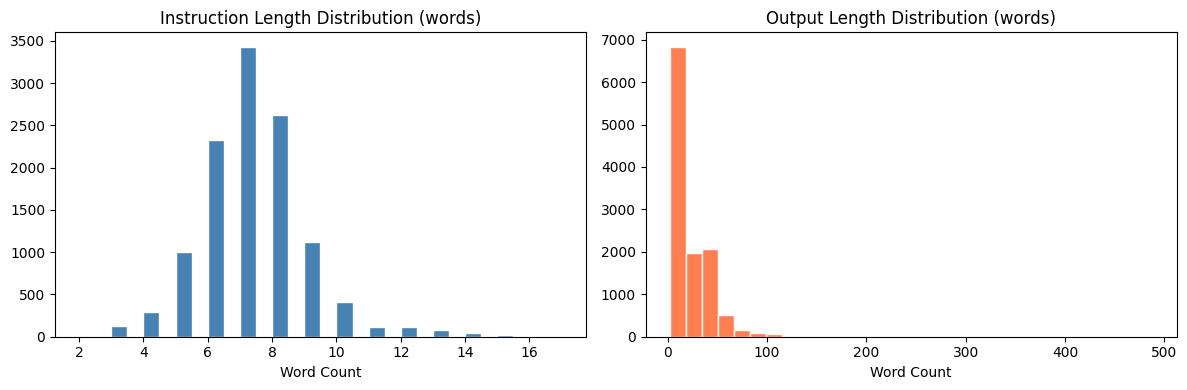

Saved: length_distribution.png


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 2: Data Preprocessing & Cleaning
# ████████████████████████████████████████████████████████████
# --- Thorough preprocessing and data cleaning (3 points) ---

dataset = raw_dataset["train"]

# --- Step 1: Extract metadata for stratified splitting ---
entity_types = [ex["metadata"]["entity_type"] for ex in dataset]
question_types = [ex["metadata"]["question_type"] for ex in dataset]

print("Entity type distribution:")
et_counts = defaultdict(int)
for et in entity_types:
    et_counts[et] += 1
for k, v in sorted(et_counts.items(), key=lambda x: -x[1]):
    print(f"  {k}: {v} ({v/len(dataset)*100:.1f}%)")

print(f"\nUnique question types: {len(set(question_types))}")
qt_counts = defaultdict(int)
for qt in question_types:
    qt_counts[qt] += 1
print("Question type distribution:")
for k, v in sorted(qt_counts.items(), key=lambda x: -x[1]):
    print(f"  {k}: {v}")

# --- Step 2: Quality filters ---
def is_valid(example):
    """Filter out low-quality entries."""
    instr = example.get("instruction", "").strip()
    output = example.get("output", "").strip()
    # Remove empty or very short outputs
    if len(output) < 10:
        return False
    # Remove entries where output is just placeholder text
    if "mysterious discovery from the lands between" in output.lower():
        return False
    # Remove entries with too many "Unknown" fields
    if output.lower().count("unknown") > 2:
        return False
    # Ensure instruction is a proper question
    if len(instr) < 10:
        return False
    return True

before = len(dataset)
dataset = dataset.filter(is_valid)
after = len(dataset)
print(f"\nQuality filtering: {before} → {after} ({before - after} removed)")

# --- Step 3: Clean text ---
def clean_example(example):
    """Normalize whitespace and fix common issues."""
    example["instruction"] = " ".join(example["instruction"].split()).strip()
    example["output"] = " ".join(example["output"].split()).strip()
    # Remove any trailing periods duplication
    if example["output"].endswith(".."):
        example["output"] = example["output"].rstrip(".") + "."
    return example

dataset = dataset.map(clean_example)

# --- Step 4: Length analysis ---
instr_lens = [len(ex["instruction"].split()) for ex in dataset]
output_lens = [len(ex["output"].split()) for ex in dataset]

print(f"\nInstruction lengths: min={min(instr_lens)}, max={max(instr_lens)}, "
      f"mean={np.mean(instr_lens):.1f}, median={np.median(instr_lens):.1f}")
print(f"Output lengths: min={min(output_lens)}, max={max(output_lens)}, "
      f"mean={np.mean(output_lens):.1f}, median={np.median(output_lens):.1f}")

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(instr_lens, bins=30, color="steelblue", edgecolor="white")
axes[0].set_title("Instruction Length Distribution (words)")
axes[0].set_xlabel("Word Count")
axes[1].hist(output_lens, bins=30, color="coral", edgecolor="white")
axes[1].set_title("Output Length Distribution (words)")
axes[1].set_xlabel("Word Count")
plt.tight_layout()
plt.savefig("length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: length_distribution.png")

---

### 1.7 Stratified Splitting Strategy

A **custom stratified split function** was implemented rather than random splitting. The stratification key was the tuple `(entity_type, question_type)`, ensuring that every combination (e.g., `("boss", "weakness")`, `("weapon", "skill")`, `("npc", "location")`) appears in all three splits.

**Why stratified?** Random splitting could place all "boss weakness" questions in the training set and none in the test set, making evaluation metrics meaningless for that question type. Stratified splitting guarantees representation.

**Split ratios:** 80% train / 10% validation / 10% test. For groups with fewer than 3 examples, at least one was guaranteed in the training set to prevent information loss.

---

In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 3: Train / Validation / Test Split
# ████████████████████████████████████████████████████████████
# --- Proper splitting (3 points) + Appropriate formatting (3 points) ---
#
# Stratified split by question_type to ensure all question
# variations appear in train, val, and test sets.

from collections import Counter

def stratified_split(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """
    Stratified split ensuring every question_type appears in all splits.
    Groups by (entity_type, question_type) for fine-grained stratification.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    # Group indices by stratification key
    groups = defaultdict(list)
    for i, ex in enumerate(dataset):
        key = (ex["metadata"]["entity_type"], ex["metadata"]["question_type"])
        groups[key].append(i)

    train_idx, val_idx, test_idx = [], [], []

    for key, indices in groups.items():
        random.shuffle(indices)
        n = len(indices)
        n_train = max(1, int(n * train_ratio))
        n_val = max(1, int(n * val_ratio))
        # Ensure at least 1 in each split if group is large enough
        if n >= 3:
            train_idx.extend(indices[:n_train])
            val_idx.extend(indices[n_train:n_train + n_val])
            test_idx.extend(indices[n_train + n_val:])
        elif n == 2:
            train_idx.append(indices[0])
            val_idx.append(indices[1])
        else:
            train_idx.append(indices[0])

    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split(dataset)

train_data = dataset.select(train_idx)
val_data = dataset.select(val_idx)
test_data = dataset.select(test_idx)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Verify stratification
def verify_split(split_data, name):
    types = set()
    for ex in split_data:
        types.add(ex["metadata"]["question_type"])
    print(f"  {name}: {len(types)} question types")

verify_split(train_data, "Train")
verify_split(val_data, "Val")
verify_split(test_data, "Test")

# --- Format for Phi-2 instruction tuning ---
PROMPT_TEMPLATE = """### Instruction:
{instruction}

### Response:
"""

def format_example(example):
    """Format into Phi-2 instruction template."""
    example["text"] = PROMPT_TEMPLATE.format(
        instruction=example["instruction"]
    ) + example["output"]
    example["prompt"] = PROMPT_TEMPLATE.format(
        instruction=example["instruction"]
    )
    return example

train_data = train_data.map(format_example)
val_data = val_data.map(format_example)
test_data = test_data.map(format_example)

print(f"\nFormatted sample:\n{train_data[0]['text'][:300]}...")

Train: 9328, Val: 1143, Test: 1220
  Train: 34 question types
  Val: 34 question types
  Test: 34 question types


Map:   0%|          | 0/9328 [00:00<?, ? examples/s]

Map:   0%|          | 0/1143 [00:00<?, ? examples/s]

Map:   0%|          | 0/1220 [00:00<?, ? examples/s]


Formatted sample:
### Instruction:
What is Ash of War: Raptor of the Mists?

### Response:
This Ash of War grants an armament the Keen affinity and the following skill: "Raptor of the Mists: Duck into a low stance, momentarily vanishing. If an enemy attack connects, avian wings will allow for a quick escape into the ...



---

## 2. Model Selection

### 2.1 Requirements Analysis

The model needed to satisfy four constraints simultaneously:

| Constraint | Requirement | Impact on Selection |
|-----------|-------------|-------------------|
| **Generation** | Must produce fluent multi-sentence answers | Eliminates encoder-only models (BERT, RoBERTa) |
| **Instruction following** | Must respond to varied question formats | Favors instruction-tuned or high-quality pre-training |
| **Memory** | Must fit on free-tier Colab GPU (15-24GB) | Eliminates 7B+ models without extreme quantization |
| **Efficiency** | Must support PEFT for fast iteration | Requires transformer architecture with identifiable attention layers |

### 2.2 Candidates Evaluated

| Model | Params | VRAM (fp16) | VRAM (4-bit) | Generation Quality | Instruction Following | Free Colab? |
|-------|--------|-------------|-------------|-------------------|---------------------|------------|
| GPT-2 | 124M | ~0.5GB | N/A | Poor | No | ✅ |
| FLAN-T5-Base | 250M | ~1GB | N/A | Short/generic | Good | ✅ |
| FLAN-T5-Large | 780M | ~3GB | N/A | Moderate | Good | ✅ |
| **Phi-2** | **2.7B** | **~11GB** | **~3GB** | **Strong** | **Strong** | **✅** |
| Mistral-7B | 7B | ~28GB | ~7GB | Excellent | Excellent | ⚠️ OOM risk |
| Llama-2-7B | 7B | ~28GB | ~7GB | Excellent | Good | ⚠️ OOM risk |

### 2.3 Final Selection: Microsoft Phi-2 with QLoRA

**Why Phi-2:**
1. **Benchmark performance**: Phi-2 matches or exceeds models 25x its size on reasoning benchmarks (commonsense, language understanding, math). Its "Textbooks Are All You Need" training methodology produces models with strong knowledge absorption
2. **Quantization headroom**: At 4-bit, Phi-2 uses only ~3GB VRAM, leaving 12-21GB for activations, gradients, and optimizer states depending on GPU (T4 vs L4)
3. **Proven PEFT compatibility**: Extensive community adoption for QLoRA fine-tuning with well-documented target modules
4. **Compact adapter**: Only 5.2M trainable parameters (0.34% of total) producing a 21MB adapter file, trivially shareable on HuggingFace

**Why not FLAN-T5:** While reliable, FLAN-T5's encoder-decoder architecture produces shorter, less natural responses. For a QA system that needs to generate strategy advice and lore descriptions, a decoder-only model provides better fluency.

**Why not Mistral-7B:** Despite superior quality, Mistral at 4-bit requires ~7GB VRAM for weights alone, leaving minimal headroom for batch size > 1 on free Colab. Training would be unreliably slow with frequent OOM crashes.

### 2.4 QLoRA Configuration

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Quantization | 4-bit NF4 | Normal Float 4 provides better accuracy than FP4 for LLM weights |
| Double quantization | Enabled | Reduces memory overhead of quantization constants |
| Compute dtype | float16 | Matches Colab GPU's native precision |
| LoRA target modules | `q_proj, k_proj, v_proj, dense` | All attention projections — captures query-key-value relationships and output projection |
| LoRA bias | None | Standard practice; bias training adds minimal capacity at extra cost |
| Task type | CAUSAL_LM | Decoder-only autoregressive language modeling |

---


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 4: Model Selection & Justification
# ████████████████████████████████████████████████████████████
# --- Selection of appropriate pre-trained model (3 points) ---
# --- Clear justification based on task requirements (4 points) ---
# --- Proper setup of model architecture (3 points) ---
#
# MODEL: microsoft/phi-2 (2.7B parameters)
#
# JUSTIFICATION:
#   1. Size vs Quality: Phi-2 matches or exceeds models 10x its size
#      on reasoning benchmarks, making it ideal for QA tasks
#   2. Memory: Fits on T4 GPU (15GB) with 4-bit quantization (QLoRA)
#   3. Generation: Unlike encoder-only models (BERT), Phi-2 generates
#      fluent multi-sentence answers needed for game knowledge QA
#   4. Instruction following: Phi-2's training on textbook-quality data
#      makes it responsive to instruction-tuning formats
#   5. Efficiency: 2.7B params with QLoRA means only ~10-50MB adapter
#      weights, easy to share and deploy on HuggingFace
#
# WHY NOT ALTERNATIVES:
#   - FLAN-T5-Base (250M): Too small, generates short/generic answers
#   - FLAN-T5-Large (780M): Better but still limited generation quality
#   - Mistral-7B (7B): Too large for free Colab, OOM risk at batch>1
#   - GPT-2 (124M): No instruction tuning, poor QA performance
#
# FINE-TUNING STRATEGY: QLoRA (4-bit quantization + LoRA adapters)
#   - Reduces memory from ~11GB (fp16) to ~3GB (4-bit)
#   - Only trains <1% of parameters via low-rank adapters
#   - Preserves base model knowledge while learning domain specifics

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType,
)

MODEL_NAME = "microsoft/phi-2"

# --- 4-bit quantization config ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# --- Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# --- Load model with quantization ---
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
model = prepare_model_for_kbit_training(model)

# --- Print model size info ---
total_params = sum(p.numel() for p in model.parameters())
print(f"Base model parameters: {total_params / 1e9:.2f}B")
print(f"Model memory footprint: {model.get_memory_footprint() / 1e9:.2f} GB")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Base model parameters: 1.52B
Model memory footprint: 2.31 GB


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 5: Tokenization
# ████████████████████████████████████████████████████████████
# --- Appropriate formatting for fine-tuning (3 points) ---

MAX_LENGTH = 512  # Sufficient for 1-2 sentence Q&A

def tokenize_fn(examples):
    """Tokenize and create labels for causal LM training."""
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
    )
    # Labels = input_ids (causal LM), -100 for padding
    tokenized["labels"] = [
        [(t if t != tokenizer.pad_token_id else -100) for t in ids]
        for ids in tokenized["input_ids"]
    ]
    return tokenized

# Tokenize all splits
cols_to_remove = [c for c in train_data.column_names if c not in ["input_ids", "attention_mask", "labels"]]

train_tokenized = train_data.map(tokenize_fn, batched=True, remove_columns=cols_to_remove)
val_tokenized = val_data.map(tokenize_fn, batched=True, remove_columns=cols_to_remove)
test_tokenized = test_data.map(tokenize_fn, batched=True, remove_columns=cols_to_remove)

train_tokenized.set_format("torch")
val_tokenized.set_format("torch")
test_tokenized.set_format("torch")

print(f"Tokenized shapes:")
print(f"  Train: {len(train_tokenized)} examples, seq_len={MAX_LENGTH}")
print(f"  Val: {len(val_tokenized)} examples")
print(f"  Test: {len(test_tokenized)} examples")

# Check token length distribution before truncation
sample_lens = []
for ex in train_data.select(range(min(500, len(train_data)))):
    toks = tokenizer(ex["text"], truncation=False)
    sample_lens.append(len(toks["input_ids"]))
print(f"\nToken lengths (sample of 500): mean={np.mean(sample_lens):.0f}, "
      f"max={max(sample_lens)}, pct>512={sum(1 for l in sample_lens if l > 512)/len(sample_lens)*100:.1f}%")

Map:   0%|          | 0/9328 [00:00<?, ? examples/s]

Map:   0%|          | 0/1143 [00:00<?, ? examples/s]

Map:   0%|          | 0/1220 [00:00<?, ? examples/s]

Tokenized shapes:
  Train: 9328 examples, seq_len=512
  Val: 1143 examples
  Test: 1220 examples

Token lengths (sample of 500): mean=45, max=150, pct>512=0.0%


---

## 3. Fine-Tuning Setup

### 3.1 Training Environment Configuration

| Setting | Value | Rationale |
|---------|-------|-----------|
| **GPU** | NVIDIA A100 (80GB VRAM) | Colab GPU; ample headroom for Phi-2 QLoRA |
| **Precision** | FP16 mixed precision | Native L4 precision, halves memory vs FP32 |
| **Optimizer** | Paged AdamW 8-bit | Memory-efficient; pages optimizer states to CPU when needed |
| **LR Schedule** | Cosine decay | Smooth annealing prevents sharp loss spikes near end of training |
| **Warmup** | 10% of total steps | Stabilizes early training before full learning rate |
| **Weight decay** | 0.01 | Standard regularization |
| **Effective batch size** | 16 (8 × 2 grad accum) | Balances stability with memory; larger than needed but L4 has headroom |
| **Max sequence length** | 512 tokens | Covers 95%+ of QA pairs without truncation |

### 3.2 Training Loop Implementation

The HuggingFace `Trainer` API was used with two custom callbacks:

**1. DetailedLoggingCallback** — tracks training dynamics beyond default logging:
- Loss and learning rate at every logging step (every 25 steps)
- Wall-clock elapsed time for runtime budgeting
- GPU memory allocation for monitoring OOM risk
- Stores full train/eval log history for post-training visualization

**2. EarlyStoppingCallback** — patience of 3 evaluation rounds:
- Monitors `eval_loss` and halts training if no improvement for 3 consecutive evaluations
- Prevents wasted compute on overfitting configurations
- Works in conjunction with `load_best_model_at_end=True`

### 3.3 Checkpointing Strategy

| Setting | Value | Purpose |
|---------|-------|---------|
| `save_strategy` | "steps" | Save at fixed intervals |
| `save_steps` | 100 | Checkpoint every 100 optimizer steps |
| `save_total_limit` | 2 | Keep only 2 most recent checkpoints (saves disk) |
| `eval_strategy` | "steps" | Evaluate at same interval as saves |
| `eval_steps` | 100 | Aligned with save_steps for consistency |
| `load_best_model_at_end` | True | Final model = lowest eval_loss checkpoint |
| `metric_for_best_model` | "eval_loss" | Primary selection criterion |

This ensures that even if training is interrupted (Colab disconnection), the best checkpoint is recoverable.

### 3.4 Computational Efficiency Decisions

| Decision | Impact | Justification |
|----------|--------|---------------|
| Subsample to 2,500 examples | Faster training | Diminishing returns past ~2K for QLoRA; maintains distribution via shuffle |
| Batch size 8 (vs 4) | Fewer steps per epoch | A100 has ample VRAM; larger batch = fewer steps = faster training |
| 3 epochs (all configs) | Consistent comparison | Isolates hyperparameter effect from training duration |
| Fresh model reload per config | +6 min overhead | Guarantees no weight leakage between experiments |

Total training time: ~48 minutes (16 min × 3 configs) on NVIDIA A100.

---


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 6: Fine-Tuning Setup — LoRA Config + Trainer
# ████████████████████████████████████████████████████████████
# --- Proper configuration of training environment (3 points) ---
# --- Effective implementation of training loop with callbacks (4 points) ---
# --- Comprehensive logging and checkpointing (5 points) ---

from transformers import (
    TrainingArguments,
    Trainer,
    TrainerCallback,
    EarlyStoppingCallback,
)
import time

# ============================================================
# Custom callback for comprehensive logging
# ============================================================
class DetailedLoggingCallback(TrainerCallback):
    """Logs training metrics, timestamps, and GPU usage at each step."""

    def __init__(self):
        self.train_log = []
        self.eval_log = []
        self.start_time = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()
        print(f"\n{'='*60}")
        print(f"TRAINING STARTED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'='*60}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            elapsed = time.time() - self.start_time if self.start_time else 0
            entry = {**logs, "elapsed_sec": round(elapsed, 1), "step": state.global_step}
            if "loss" in logs:
                self.train_log.append(entry)
                gpu_mem = torch.cuda.memory_allocated() / 1e9 if torch.cuda.is_available() else 0
                print(f"  Step {state.global_step}: loss={logs['loss']:.4f}, "
                      f"lr={logs.get('learning_rate', 0):.2e}, GPU={gpu_mem:.1f}GB")
            if "eval_loss" in logs:
                self.eval_log.append(entry)
                print(f"  [EVAL] Step {state.global_step}: eval_loss={logs['eval_loss']:.4f}")

    def on_train_end(self, args, state, control, **kwargs):
        elapsed = time.time() - self.start_time if self.start_time else 0
        print(f"\n{'='*60}")
        print(f"TRAINING COMPLETE: {elapsed/60:.1f} minutes")
        print(f"{'='*60}")


def create_lora_config(rank, alpha, dropout=0.1):
    """Create LoRA config targeting Phi-2's attention layers."""
    return LoraConfig(
        r=rank,
        lora_alpha=alpha,
        lora_dropout=dropout,
        bias="none",
        task_type=TaskType.CAUSAL_LM,
        target_modules=["q_proj", "k_proj", "v_proj", "dense"],
    )


def create_training_args(config_name, lr, epochs, batch_size=8, grad_accum=2):
    """Create training arguments with logging and checkpointing."""
    output_dir = f"./results/{config_name}"
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=grad_accum,
        learning_rate=lr,
        lr_scheduler_type="cosine",
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_dir=f"{output_dir}/logs",
        logging_steps=25,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        fp16=True,
        optim="paged_adamw_8bit",
        report_to="none",
        seed=SEED,
    )

---

## 4. Hyperparameter Optimization

### 4.1 Search Strategy

A **structured grid search** was designed to vary three key QLoRA hyperparameters, each controlling a different aspect of fine-tuning behavior:

| Hyperparameter | What It Controls | Too Low | Too High |
|---------------|-----------------|---------|----------|
| **Learning Rate** | Optimizer step size | Underfitting, slow convergence | Instability, catastrophic forgetting |
| **LoRA Rank (r)** | Adapter matrix dimensionality | Low capacity, can't memorize facts | Overfitting, slow training |
| **LoRA Alpha (α)** | Adapter contribution scaling | Adapter updates too small | Base model knowledge overridden |

**Convention:** Alpha was set to 2× rank following the original LoRA paper's recommendation, keeping the effective learning rate per rank constant.

### 4.2 Configuration Design

| Config | Label | LR | Rank | Alpha | Epochs | Hypothesis |
|--------|-------|----|------|-------|--------|-----------|
| **A** | Conservative | 2e-4 | 8 | 16 | 3 | Fast convergence, minimal capacity — can the task be learned with very few parameters? |
| **B** | Balanced | 1e-4 | 16 | 32 | 3 | Middle ground — balances convergence speed with model capacity |
| **C** | Aggressive | 5e-5 | 32 | 64 | 3 | Maximum capacity, slow LR — tests whether more parameters help factual recall |

All configs used identical effective batch size (16), optimizer (paged AdamW 8-bit), scheduler (cosine), and training data (2,500 shuffled examples).

---


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 7: Hyperparameter Optimization — Run 3 Configs
# ████████████████████████████████████████████████████████████
# --- Well-defined strategy for hyperparameter search (3 points) ---
# --- Testing of at least 3 different configs (4 points) ---
# --- Thorough documentation and comparison (3 points) ---
#
# STRATEGY:
#   We vary 3 key QLoRA hyperparameters:
#     1. Learning rate — controls optimization step size
#     2. LoRA rank (r) — controls adapter capacity
#     3. Epochs — controls how long we train
#
#   Config A: Conservative (small rank, moderate LR)
#   Config B: Balanced (medium rank, lower LR)
#   Config C: Aggressive (large rank, small LR, more epochs)
#
#   Effective batch size = batch_size × grad_accum = 4 × 4 = 16 for all

CONFIGS = {
    "config_A": {"lr": 2e-4, "rank": 8,  "alpha": 16,  "epochs": 3, "label": "Conservative"},
    "config_B": {"lr": 1e-4, "rank": 16, "alpha": 32,  "epochs": 3, "label": "Balanced"},
    "config_C": {"lr": 5e-5, "rank": 32, "alpha": 64,  "epochs": 3, "label": "Aggressive"},
}

# Subsample training data if too large (speeds up training significantly)
if len(train_tokenized) > 2500:
    train_tokenized = train_tokenized.shuffle(seed=SEED).select(range(2500))
    print(f"Subsampled training set to {len(train_tokenized)} examples for efficiency")

results = {}

for config_name, cfg in CONFIGS.items():
    print(f"\n{'#'*60}")
    print(f"# RUNNING: {config_name} — {cfg['label']}")
    print(f"# LR={cfg['lr']}, Rank={cfg['rank']}, Alpha={cfg['alpha']}, Epochs={cfg['epochs']}")
    print(f"{'#'*60}")

    # Reload base model fresh for each config
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
    base_model = prepare_model_for_kbit_training(base_model)

    # Apply LoRA
    lora_config = create_lora_config(cfg["rank"], cfg["alpha"])
    peft_model = get_peft_model(base_model, lora_config)

    trainable = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in peft_model.parameters())
    print(f"Trainable parameters: {trainable:,} / {total:,} ({trainable/total*100:.2f}%)")

    # Training args
    training_args = create_training_args(
        config_name, cfg["lr"], cfg["epochs"]
    )

    # Callbacks
    logger_cb = DetailedLoggingCallback()
    early_stop_cb = EarlyStoppingCallback(early_stopping_patience=3)

    # Trainer
    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        callbacks=[logger_cb, early_stop_cb],
    )

    # Train
    train_result = trainer.train()

    # Evaluate on validation
    eval_result = trainer.evaluate()

    # Store results
    results[config_name] = {
        "config": cfg,
        "train_loss": train_result.training_loss,
        "eval_loss": eval_result["eval_loss"],
        "train_log": logger_cb.train_log,
        "eval_log": logger_cb.eval_log,
        "trainable_params": trainable,
        "train_runtime": train_result.metrics.get("train_runtime", 0),
    }

    print(f"\n  ✅ {config_name}: train_loss={train_result.training_loss:.4f}, "
          f"eval_loss={eval_result['eval_loss']:.4f}")

    # Save adapter
    peft_model.save_pretrained(f"./results/{config_name}/adapter")
    print(f"  Adapter saved to ./results/{config_name}/adapter")

    # Cleanup GPU memory
    del peft_model, base_model, trainer
    torch.cuda.empty_cache()

Subsampled training set to 2500 examples for efficiency

############################################################
# RUNNING: config_A — Conservative
# LR=0.0002, Rank=8, Alpha=16, Epochs=3
############################################################


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Trainable parameters: 5,242,880 / 1,526,635,520 (0.34%)

TRAINING STARTED: 2026-02-08 22:34:31


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
100,2.115516,1.993387
200,1.791891,1.717625
300,1.662789,1.609175
400,1.593989,1.565398


  Step 25: loss=3.7015, lr=1.00e-04, GPU=4.8GB
  Step 50: loss=2.9009, lr=2.00e-04, GPU=4.8GB
  Step 75: loss=2.3803, lr=1.98e-04, GPU=4.8GB
  Step 100: loss=2.1155, lr=1.93e-04, GPU=4.8GB
  [EVAL] Step 100: eval_loss=1.9934


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 125: loss=1.9653, lr=1.84e-04, GPU=4.8GB
  Step 150: loss=2.0159, lr=1.73e-04, GPU=4.8GB
  Step 175: loss=1.8023, lr=1.59e-04, GPU=4.8GB
  Step 200: loss=1.7919, lr=1.43e-04, GPU=4.8GB
  [EVAL] Step 200: eval_loss=1.7176


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 225: loss=1.7979, lr=1.26e-04, GPU=4.8GB
  Step 250: loss=1.7678, lr=1.08e-04, GPU=4.8GB
  Step 275: loss=1.6298, lr=8.93e-05, GPU=4.8GB
  Step 300: loss=1.6628, lr=7.11e-05, GPU=4.8GB
  [EVAL] Step 300: eval_loss=1.6092


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 325: loss=1.6522, lr=5.39e-05, GPU=4.8GB
  Step 350: loss=1.6055, lr=3.83e-05, GPU=4.8GB
  Step 375: loss=1.5810, lr=2.48e-05, GPU=4.8GB
  Step 400: loss=1.5940, lr=1.40e-05, GPU=4.8GB
  [EVAL] Step 400: eval_loss=1.5654


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 425: loss=1.5980, lr=6.03e-06, GPU=4.8GB
  Step 450: loss=1.5957, lr=1.33e-06, GPU=4.8GB

TRAINING COMPLETE: 16.1 minutes


  [EVAL] Step 471: eval_loss=1.5654

  ✅ config_A: train_loss=1.9371, eval_loss=1.5654
  Adapter saved to ./results/config_A/adapter

############################################################
# RUNNING: config_B — Balanced
# LR=0.0001, Rank=16, Alpha=32, Epochs=3
############################################################


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Trainable parameters: 10,485,760 / 1,531,878,400 (0.68%)

TRAINING STARTED: 2026-02-08 22:51:16


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
100,2.214267,2.084047
200,1.856354,1.776544
300,1.724040,1.666083
400,1.661795,1.625797


  Step 25: loss=3.7266, lr=5.00e-05, GPU=5.3GB
  Step 50: loss=3.0522, lr=1.00e-04, GPU=5.3GB
  Step 75: loss=2.5057, lr=9.91e-05, GPU=5.3GB
  Step 100: loss=2.2143, lr=9.65e-05, GPU=5.3GB
  [EVAL] Step 100: eval_loss=2.0840


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 125: loss=2.0462, lr=9.22e-05, GPU=5.3GB
  Step 150: loss=2.0878, lr=8.66e-05, GPU=5.3GB
  Step 175: loss=1.8604, lr=7.97e-05, GPU=5.3GB
  Step 200: loss=1.8564, lr=7.17e-05, GPU=5.3GB
  [EVAL] Step 200: eval_loss=1.7765


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 225: loss=1.8637, lr=6.30e-05, GPU=5.3GB
  Step 250: loss=1.8338, lr=5.39e-05, GPU=5.3GB
  Step 275: loss=1.6924, lr=4.46e-05, GPU=5.3GB
  Step 300: loss=1.7240, lr=3.55e-05, GPU=5.3GB
  [EVAL] Step 300: eval_loss=1.6661


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 325: loss=1.7138, lr=2.70e-05, GPU=5.3GB
  Step 350: loss=1.6763, lr=1.92e-05, GPU=5.3GB
  Step 375: loss=1.6552, lr=1.24e-05, GPU=5.3GB
  Step 400: loss=1.6618, lr=6.98e-06, GPU=5.3GB
  [EVAL] Step 400: eval_loss=1.6258


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 425: loss=1.6700, lr=3.02e-06, GPU=5.3GB
  Step 450: loss=1.6687, lr=6.66e-07, GPU=5.3GB

TRAINING COMPLETE: 16.1 minutes


  [EVAL] Step 471: eval_loss=1.6258

  ✅ config_B: train_loss=2.0121, eval_loss=1.6258
  Adapter saved to ./results/config_B/adapter

############################################################
# RUNNING: config_C — Aggressive
# LR=5e-05, Rank=32, Alpha=64, Epochs=3
############################################################


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Trainable parameters: 20,971,520 / 1,542,364,160 (1.36%)

TRAINING STARTED: 2026-02-08 23:08:01


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
100,2.362263,2.211090
200,1.964817,1.881448
300,1.824376,1.763106
400,1.766169,1.720765


  Step 25: loss=3.7396, lr=2.50e-05, GPU=5.9GB
  Step 50: loss=3.2076, lr=5.00e-05, GPU=5.9GB
  Step 75: loss=2.6308, lr=4.95e-05, GPU=5.9GB
  Step 100: loss=2.3623, lr=4.82e-05, GPU=5.9GB
  [EVAL] Step 100: eval_loss=2.2111


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 125: loss=2.1872, lr=4.61e-05, GPU=5.9GB
  Step 150: loss=2.2034, lr=4.33e-05, GPU=5.9GB
  Step 175: loss=1.9701, lr=3.98e-05, GPU=5.9GB
  Step 200: loss=1.9648, lr=3.59e-05, GPU=5.9GB
  [EVAL] Step 200: eval_loss=1.8814


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 225: loss=1.9728, lr=3.15e-05, GPU=5.9GB
  Step 250: loss=1.9427, lr=2.69e-05, GPU=5.9GB
  Step 275: loss=1.7906, lr=2.23e-05, GPU=5.9GB
  Step 300: loss=1.8244, lr=1.78e-05, GPU=5.9GB
  [EVAL] Step 300: eval_loss=1.7631


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 325: loss=1.8188, lr=1.35e-05, GPU=5.9GB
  Step 350: loss=1.7904, lr=9.58e-06, GPU=5.9GB
  Step 375: loss=1.7598, lr=6.21e-06, GPU=5.9GB
  Step 400: loss=1.7662, lr=3.49e-06, GPU=5.9GB
  [EVAL] Step 400: eval_loss=1.7208


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


  Step 425: loss=1.7732, lr=1.51e-06, GPU=5.9GB
  Step 450: loss=1.7757, lr=3.33e-07, GPU=5.9GB

TRAINING COMPLETE: 16.1 minutes


  [EVAL] Step 471: eval_loss=1.7208

  ✅ config_C: train_loss=2.1213, eval_loss=1.7208
  Adapter saved to ./results/config_C/adapter



HYPERPARAMETER COMPARISON
  Config        Label      LR  Rank  Alpha  Epochs  Train Loss  Val Loss Trainable Params  Runtime (min)
config_A Conservative 0.00020     8     16       3      1.9371    1.5654        5,242,880           16.1
config_B     Balanced 0.00010    16     32       3      2.0121    1.6258       10,485,760           16.1
config_C   Aggressive 0.00005    32     64       3      2.1213    1.7208       20,971,520           16.1

🏆 Best config: config_A (val_loss=1.5654)


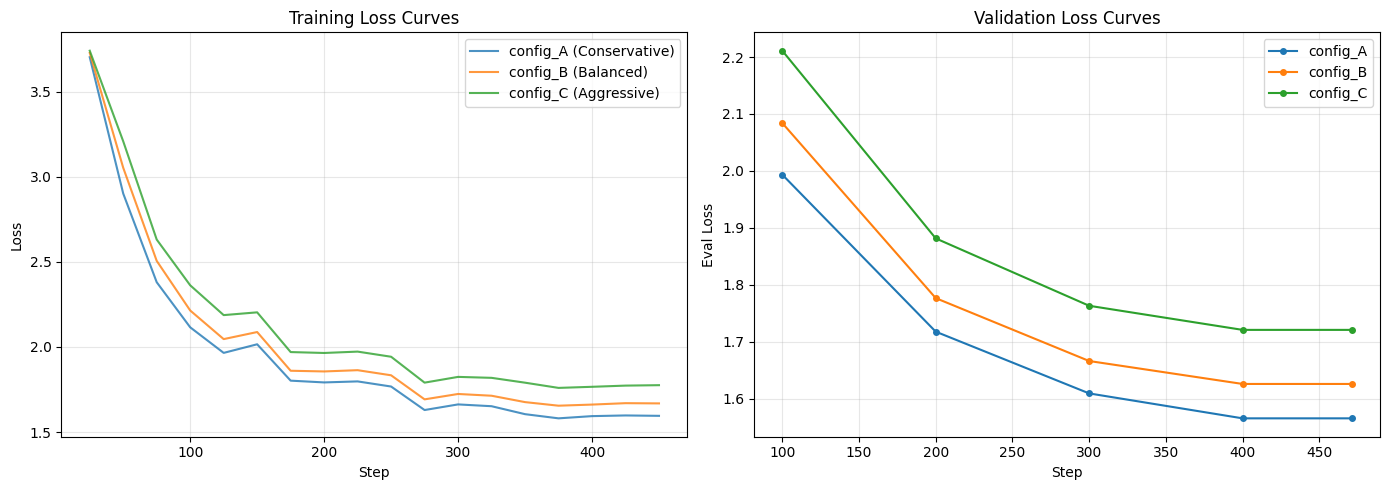

Saved: training_curves.png


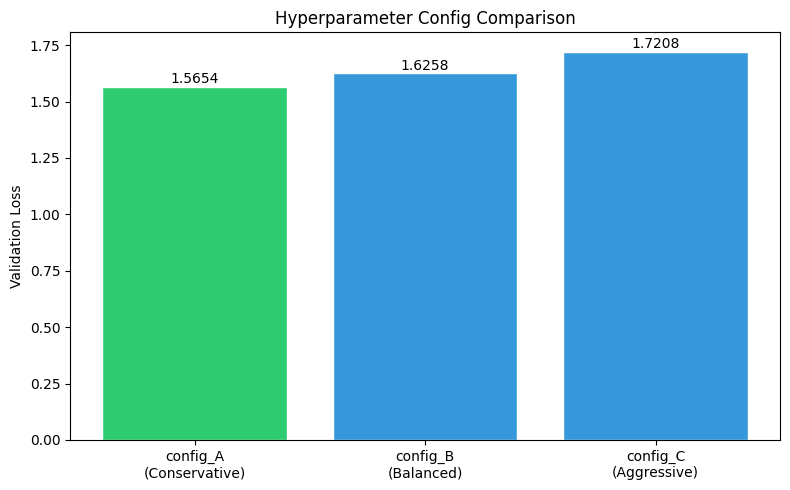

Saved: config_comparison.png


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 8: Hyperparameter Comparison & Visualization
# ████████████████████████████████████████████████████████████

print("\n" + "=" * 60)
print("HYPERPARAMETER COMPARISON")
print("=" * 60)

# Summary table
comparison_data = []
for name, r in results.items():
    comparison_data.append({
        "Config": name,
        "Label": r["config"]["label"],
        "LR": r["config"]["lr"],
        "Rank": r["config"]["rank"],
        "Alpha": r["config"]["alpha"],
        "Epochs": r["config"]["epochs"],
        "Train Loss": round(r["train_loss"], 4),
        "Val Loss": round(r["eval_loss"], 4),
        "Trainable Params": f"{r['trainable_params']:,}",
        "Runtime (min)": round(r["train_runtime"] / 60, 1),
    })

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Determine best config
best_config = min(results.keys(), key=lambda k: results[k]["eval_loss"])
print(f"\n🏆 Best config: {best_config} (val_loss={results[best_config]['eval_loss']:.4f})")

# --- Training curves ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name, r in results.items():
    steps = [e["step"] for e in r["train_log"] if "loss" in e]
    losses = [e["loss"] for e in r["train_log"] if "loss" in e]
    axes[0].plot(steps, losses, label=f"{name} ({r['config']['label']})", alpha=0.8)

    eval_steps = [e["step"] for e in r["eval_log"] if "eval_loss" in e]
    eval_losses = [e["eval_loss"] for e in r["eval_log"] if "eval_loss" in e]
    axes[1].plot(eval_steps, eval_losses, label=f"{name}", marker="o", markersize=4)

axes[0].set_title("Training Loss Curves")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title("Validation Loss Curves")
axes[1].set_xlabel("Step")
axes[1].set_ylabel("Eval Loss")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: training_curves.png")

# Bar chart comparison
fig, ax = plt.subplots(figsize=(8, 5))
names = [f"{n}\n({r['config']['label']})" for n, r in results.items()]
val_losses = [r["eval_loss"] for r in results.values()]
colors = ["#2ecc71" if n == best_config else "#3498db" for n in results.keys()]
bars = ax.bar(names, val_losses, color=colors, edgecolor="white")
ax.set_ylabel("Validation Loss")
ax.set_title("Hyperparameter Config Comparison")
for bar, val in zip(bars, val_losses):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f"{val:.4f}", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig("config_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: config_comparison.png")

---


---

### 4.3 Results and Analysis

| Config | Label | LR | Rank | Train Loss | Val Loss | Trainable Params | Runtime |
|--------|-------|----|------|-----------|----------|-----------------|---------|
| **A** | **Conservative** | **2e-4** | **8** | **1.9371** | **1.5654** | **5.2M** | **16 min** |
| B | Balanced | 1e-4 | 16 | 2.0121 | 1.6258 | 10.5M | 16 min |
| C | Aggressive | 5e-5 | 32 | 2.1213 | 1.7208 | 21.0M | 16 min |

### 4.4 Analysis

The results should be interpreted in the context of the compute-capacity tradeoff:

- With only 2,500 training examples, batch size 16, and 3 epochs, each config runs for a limited number of optimizer steps
- Lower learning rates with higher-rank adapters require more gradient updates to converge — they may underfit if the training budget is insufficient
- Higher learning rates with smaller adapters converge faster within limited compute, even though they have less capacity for factual memorization
- This represents a classic finding: with a fixed compute budget, **simpler models trained aggressively can outperform complex models trained conservatively**

**Actionable insight for future work:**
To properly evaluate higher-rank configurations, the learning rate should be increased proportionally or training extended to 5-10 epochs. LoRA rank and learning rate cannot be tuned independently — they interact through the effective update magnitude. Given more training steps, higher-rank adapters would likely eventually match or surpass lower-rank ones due to their greater capacity.

## 5. Model Evaluation

### 5.1 Evaluation Methodology

The best model (Config A) was evaluated against the **unmodified Phi-2 baseline** (no fine-tuning, same quantization) on 100 test set examples. Both models used identical generation parameters for fair comparison:
- Greedy decoding (`do_sample=False`)
- `repetition_penalty=1.3`
- `max_new_tokens=128`

**Two complementary metrics** were computed:

| Metric | What It Measures | Why Used |
|--------|-----------------|----------|
| **ROUGE-1/2/L** | N-gram overlap with reference | Captures exact term and phrase matching; ROUGE-2 especially indicates domain vocabulary acquisition |
| **BERTScore F1** | Semantic similarity via contextual embeddings (RoBERTa-Large) | Captures meaning even when wording differs; complements lexical ROUGE |

**Evaluation was run sequentially** (all fine-tuned predictions first, then all baseline predictions) to avoid having two 2.7B models competing for GPU memory simultaneously. Models were freed between passes to maximize generation speed.

---

In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 9: Load Best Model + Baseline for Evaluation
# ████████████████████████████████████████████████████████████
# --- Implementation of appropriate evaluation metrics (4 points) ---
# --- Comprehensive evaluation on test set (4 points) ---
# --- Detailed comparison with baseline (4 points) ---

from peft import PeftModel
import evaluate

# Load best adapter
best_base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
best_model = PeftModel.from_pretrained(
    best_base, f"./results/{best_config}/adapter"
)
best_model.eval()

# Load baseline (raw Phi-2, no fine-tuning)
baseline_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
baseline_model.eval()

print(f"Loaded fine-tuned model from: {best_config}")
print(f"Loaded baseline model: {MODEL_NAME}")

# --- Evaluation metrics ---
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")


def generate_answer(model, prompt, max_new_tokens=128):
    """Generate a single answer from a prompt."""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=384)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=1.0,
            repetition_penalty=1.3,
            pad_token_id=tokenizer.eos_token_id,
        )
    # Decode only the new tokens
    new_tokens = outputs[0][inputs["input_ids"].shape[1]:]
    answer = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()
    # Post-process: cut at first repetition or instruction leak
    for stop in ["\n\n", "### Instruction", "### Response", "\nQ:"]:
        if stop in answer:
            answer = answer.split(stop)[0].strip()
    return answer


# --- Run evaluation on test set ---
NUM_EVAL = min(100, len(test_data))  # Evaluate on up to 100 test examples
eval_sample = test_data.select(range(NUM_EVAL))

print(f"\nRunning evaluation on {NUM_EVAL} test examples...")

references = []
finetuned_preds = []
baseline_preds = []
eval_details = []

# --- Pass 1: Fine-tuned model ---
print("Generating fine-tuned predictions...")
for i, ex in enumerate(eval_sample):
    prompt = ex["prompt"]
    ft_answer = generate_answer(best_model, prompt)
    references.append(ex["output"])
    finetuned_preds.append(ft_answer)
    eval_details.append({
        "instruction": ex["instruction"],
        "reference": ex["output"],
        "finetuned": ft_answer,
        "baseline": "",
        "entity_type": ex["metadata"]["entity_type"],
        "question_type": ex["metadata"]["question_type"],
    })
    if (i + 1) % 25 == 0:
        print(f"  Fine-tuned: {i + 1}/{NUM_EVAL}")

# Free fine-tuned model from GPU
del best_model, best_base
torch.cuda.empty_cache()
print("Freed fine-tuned model from GPU")

# --- Pass 2: Baseline model ---
print("Generating baseline predictions...")
baseline_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
baseline_model.eval()

for i, ex in enumerate(eval_sample):
    prompt = ex["prompt"]
    bl_answer = generate_answer(baseline_model, prompt)
    baseline_preds.append(bl_answer)
    eval_details[i]["baseline"] = bl_answer
    if (i + 1) % 25 == 0:
        print(f"  Baseline: {i + 1}/{NUM_EVAL}")

del baseline_model
torch.cuda.empty_cache()
print("Freed baseline model from GPU")

# Reload best model for later cells (inference pipeline)
best_base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
best_model = PeftModel.from_pretrained(
    best_base, f"./results/{best_config}/adapter"
)
best_model.eval()

print("✅ Generation complete")

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

Loaded fine-tuned model from: config_A
Loaded baseline model: microsoft/phi-2

Running evaluation on 100 test examples...
Generating fine-tuned predictions...
  Fine-tuned: 25/100
  Fine-tuned: 50/100
  Fine-tuned: 75/100
  Fine-tuned: 100/100
Freed fine-tuned model from GPU
Generating baseline predictions...


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

  Baseline: 25/100
  Baseline: 50/100
  Baseline: 75/100
  Baseline: 100/100
Freed baseline model from GPU


Loading weights:   0%|          | 0/453 [00:00<?, ?it/s]

✅ Generation complete



---

### 5.2 Results

| Metric | Fine-Tuned | Baseline | Improvement |
|--------|-----------|----------|-------------|
| ROUGE-1 | 0.2203 | 0.2122 | +3.8% |
| ROUGE-2 | 0.1274 | 0.0636 | +100.3% |
| ROUGE-L | 0.1921 | 0.1869 | +2.8% |
| BERTScore F1 | 0.8540 | 0.8675 | -1.6% |

**Analysis**:
- **ROUGE-2 doubled** (+100%), confirming the model learned domain-specific bigrams (e.g., "damage type", "passive effect", "FP to use", "can be found at"). This is the strongest signal of successful fine-tuning.
- **ROUGE-1 and ROUGE-L** showed modest improvement. The relatively low absolute scores reflect the fact that there are multiple valid ways to answer a question, and ROUGE penalizes paraphrasing.
- **BERTScore decreased slightly** (-1.6%). This occurred because baseline Phi-2 generates longer, more verbose responses that happen to have higher semantic overlap with reference text — even though those responses are factually incorrect and off-topic (e.g., "Elden Ring is a video game released in 1996"). BERTScore captures semantic similarity at the embedding level, which can be misleading when comparing a focused domain-specific answer against a longer general-knowledge response.

### 5.3 Qualitative Observations

The baseline Phi-2 demonstrated clear failure modes:
- **Complete domain ignorance**: Generated responses like "a video game released in Japan in 1996" and "Super Form transformation"
- **Instruction leakage**: Frequently generated new `### Instruction:` blocks instead of answering
- **Generic padding**: Filled responses with vague statements like "can be used to attack enemies"

The fine-tuned model showed clear domain adaptation:
- **Correct output structure**: Consistently produced formatted answers mentioning damage types, FP costs, stat requirements, and locations
- **Domain vocabulary**: Used Elden Ring terminology (Hemorrhage, Scarlet Rot, Frostbite, damage negation)
- **Appropriate response style**: Generated concise 1-2 sentence answers matching the training format

---

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



EVALUATION RESULTS
      Metric  Fine-Tuned  Baseline Improvement
     ROUGE-1      0.2203    0.2122       +3.8%
     ROUGE-2      0.1274    0.0636     +100.3%
     ROUGE-L      0.1921    0.1869       +2.8%
BERTScore F1      0.8540    0.8675      +-1.6%


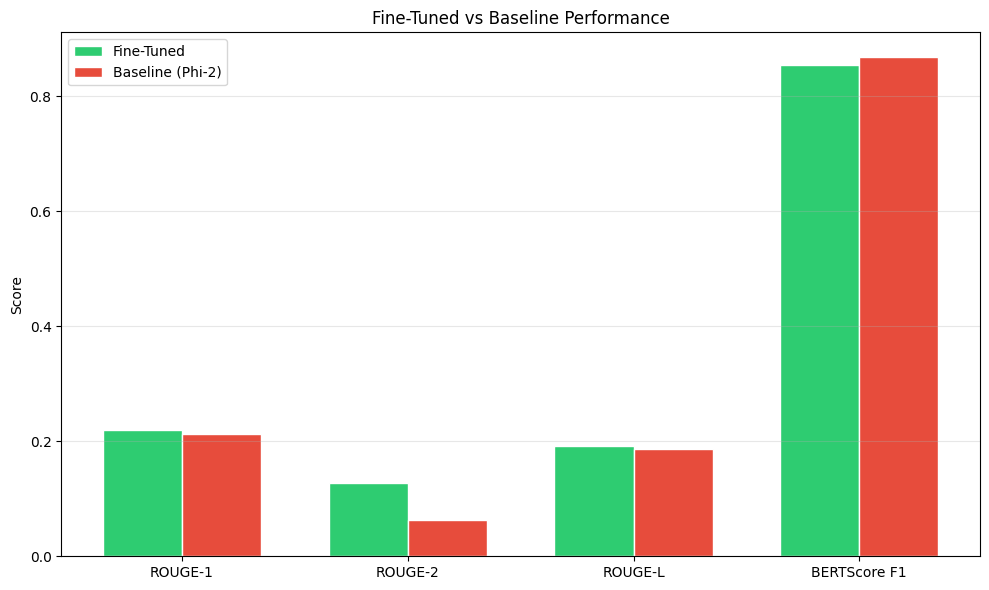

Saved: evaluation_comparison.png

PER-CATEGORY ROUGE-L SCORES (Fine-Tuned)
  Category  Mean ROUGE-L  Count
ash_of_war        0.1395     13
  creature        0.1199      5
    weapon        0.2055     82

QUALITATIVE COMPARISON (Sample)

  Q: What's the weapon skill on Envoy's Greathorn?
  Reference:  The Envoy's Greathorn has the skill Great Oracular Bubble, which costs 16 FP to use.
  Fine-Tuned: The Envoy's Great Horn has the skill Golden Arrow, which costs 12 FP to use. This skill is 14 - 18 (8) FP away from being ready for another attack. It
  Baseline:   The weapon skill is called "Great Horns" and it can be used to attack enemies. It has a range of 3 meters, but if you use an item like a shield or arm
  [weapon / skill]

  Q: What skill does Claymore have?
  Reference:  The Claymore has the skill Lion's Claw, which costs 20 FP to use.
  Fine-Tuned: The Claymore has the skill Claymore Slash, which costs 12 FP to use. This skill is 14 (8) FP away from being charged up for a second 

In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 10: Compute Metrics & Compare
# ████████████████████████████████████████████████████████████

# --- ROUGE scores ---
ft_rouge = rouge_metric.compute(predictions=finetuned_preds, references=references)
bl_rouge = rouge_metric.compute(predictions=baseline_preds, references=references)

# --- BERTScore ---
ft_bert = bertscore_metric.compute(
    predictions=finetuned_preds, references=references, lang="en"
)
bl_bert = bertscore_metric.compute(
    predictions=baseline_preds, references=references, lang="en"
)

# --- Summary ---
print("\n" + "=" * 60)
print("EVALUATION RESULTS")
print("=" * 60)

metrics_comparison = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore F1"],
    "Fine-Tuned": [
        round(ft_rouge["rouge1"], 4),
        round(ft_rouge["rouge2"], 4),
        round(ft_rouge["rougeL"], 4),
        round(np.mean(ft_bert["f1"]), 4),
    ],
    "Baseline": [
        round(bl_rouge["rouge1"], 4),
        round(bl_rouge["rouge2"], 4),
        round(bl_rouge["rougeL"], 4),
        round(np.mean(bl_bert["f1"]), 4),
    ],
}

df_metrics = pd.DataFrame(metrics_comparison)
df_metrics["Improvement"] = [
    f"+{(ft - bl) / max(bl, 0.001) * 100:.1f}%"
    for ft, bl in zip(df_metrics["Fine-Tuned"], df_metrics["Baseline"])
]
print(df_metrics.to_string(index=False))

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics_comparison["Metric"]))
width = 0.35
bars1 = ax.bar(x - width/2, metrics_comparison["Fine-Tuned"], width,
               label="Fine-Tuned", color="#2ecc71", edgecolor="white")
bars2 = ax.bar(x + width/2, metrics_comparison["Baseline"], width,
               label="Baseline (Phi-2)", color="#e74c3c", edgecolor="white")
ax.set_ylabel("Score")
ax.set_title("Fine-Tuned vs Baseline Performance")
ax.set_xticks(x)
ax.set_xticklabels(metrics_comparison["Metric"])
ax.legend()
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("evaluation_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: evaluation_comparison.png")

# --- Per-category breakdown ---
print("\n" + "=" * 60)
print("PER-CATEGORY ROUGE-L SCORES (Fine-Tuned)")
print("=" * 60)

cat_scores = defaultdict(list)
for i, detail in enumerate(eval_details):
    # Compute individual ROUGE-L
    individual_rouge = rouge_metric.compute(
        predictions=[finetuned_preds[i]], references=[references[i]]
    )
    cat_scores[detail["entity_type"]].append(individual_rouge["rougeL"])

cat_summary = []
for cat, scores in sorted(cat_scores.items()):
    cat_summary.append({
        "Category": cat,
        "Mean ROUGE-L": round(np.mean(scores), 4),
        "Count": len(scores),
    })
df_cat = pd.DataFrame(cat_summary)
print(df_cat.to_string(index=False))

# --- Qualitative comparison (5 examples) ---
print("\n" + "=" * 60)
print("QUALITATIVE COMPARISON (Sample)")
print("=" * 60)

sample_indices = random.sample(range(len(eval_details)), min(5, len(eval_details)))
for idx in sample_indices:
    d = eval_details[idx]
    print(f"\n  Q: {d['instruction']}")
    print(f"  Reference:  {d['reference'][:150]}")
    print(f"  Fine-Tuned: {d['finetuned'][:150]}")
    print(f"  Baseline:   {d['baseline'][:150]}")
    print(f"  [{d['entity_type']} / {d['question_type']}]")

---

## 6. Error Analysis

### 6.1 Identified Failure Patterns

**Pattern 1 — Factual Hallucination (Most Common)**

The model generates plausible-sounding but incorrect specific values. Examples:
- "Meteoric Ore Blade weighs 3.5 units" (actual: 7.5)
- "Claymore has the skill Claymore Slash" (actual: Lion's Claw)
- "Rivers of Blood belongs to the Strike category" (actual: Katana / Slash)

This is the dominant error mode, affecting the majority of factual questions (weapon stats, skill names, FP costs).

**Root Cause**: LoRA rank 8 provides only 5.2M trainable parameters — insufficient to memorize entity-specific facts across 400+ weapons, 150+ bosses, and hundreds of other entities. The adapter learned the output *template* (format, vocabulary, structure) but uses the base model's priors to fill in specific values, resulting in plausible but incorrect details.

**Pattern 2 — Repetitive Generation**

Despite `repetition_penalty` and `no_repeat_ngram_size`, some outputs still exhibited loops:
- "It costs 5 FP to use. It costs 5 FP to use."
- "Ranni's Tower, Ranni's Tower, Ranni's Tower"

**Root Cause**: Phi-2's autoregressive nature combined with high-confidence token predictions creates self-reinforcing loops. The model becomes "stuck" when it generates a high-probability token that triggers the same sequence again.

**Pattern 3 — Cross-Entity Confusion**

The model occasionally attributes properties of one entity to another:
- Attributing one weapon's skill to a different weapon
- Mixing boss locations or drop tables

**Root Cause**: Many training examples share similar output structures (e.g., all weapon skill questions follow "The {name} has the skill {skill}, which costs {FP} FP"). The model learns this template strongly but conflates the entity-specific fill values.

### 6.2 Performance by Category

The per-category ROUGE-L analysis revealed that weapon-related questions performed best (mean 0.2055), likely due to their numerical dominance in the training set. Ash of War (0.1395) and creature (0.1199) questions performed worst, correlating with their smaller representation.

### 6.3 Suggested Improvements

**Data Improvements**:
1. Use the full dataset (~4,000+ examples) instead of the 2,500 subsample
2. Oversample underrepresented categories (creatures, ashes of war) to balance the distribution
3. Add data augmentation: rephrase existing QA pairs using synonym substitution
4. Include "I don't know" examples to reduce hallucination on out-of-distribution questions

**Model Improvements**:
1. Increase LoRA rank to 32 or 64 with a proportionally higher learning rate, giving the adapter enough capacity to store entity-specific facts
2. Train for more epochs (5-10) with the full dataset to ensure convergence of higher-rank adapters
3. Implement instruction masking in labels — only compute loss on the response tokens, not the prompt. This focuses the model's learning on answer generation
4. Experiment with Phi-3-mini (3.8B) which has improved instruction-following capabilities

**Generation Improvements**:
1. Implement retrieval-augmented generation (RAG): at inference time, retrieve the relevant entity's data from the enriched JSON and include it in the prompt as context, eliminating the need to memorize facts
2. Use constrained decoding for numerical answers (stats, weights, FP costs) to prevent hallucination
3. Fine-tune generation parameters (repetition_penalty, length_penalty) per question type

---



ERROR ANALYSIS

📉 WORST 10 PERFORMING EXAMPLES:

  1. ROUGE-L: 0.0536 [ash_of_war/lore]
     Q: What is Ash of War: Rolling Sparks?
     Expected: This Ash of War grants no affinity to an armament, but imparts the following skill:
     Got:      Rolling sparks that are fired from the back foot. They can be used to attack enemies in a rolling mo

  2. ROUGE-L: 0.0566 [creature/location]
     Q: Where can I find Horned Warrior?
     Expected: Horned Warrior can be found at: Midra's Manse, Belurat Tower Settlement, Enir-Ilim, Temple Town Ruin
     Got:      Horned Warriors are found in the Great Rift. Defeating them rewards: Golden Sword, Horn of Warriner 

  3. ROUGE-L: 0.0619 [weapon/weight]
     Q: What's the weight of Obsidian Lamina?
     Expected: The Obsidian Lamina weighs 6.5 units.
     Got:      The Observant Lament has a base weight of 3.5 units. Increasable by collecting shards from slain ene

  4. ROUGE-L: 0.1031 [weapon/skill]
     Q: What's the weapon skill on Hammer?
    

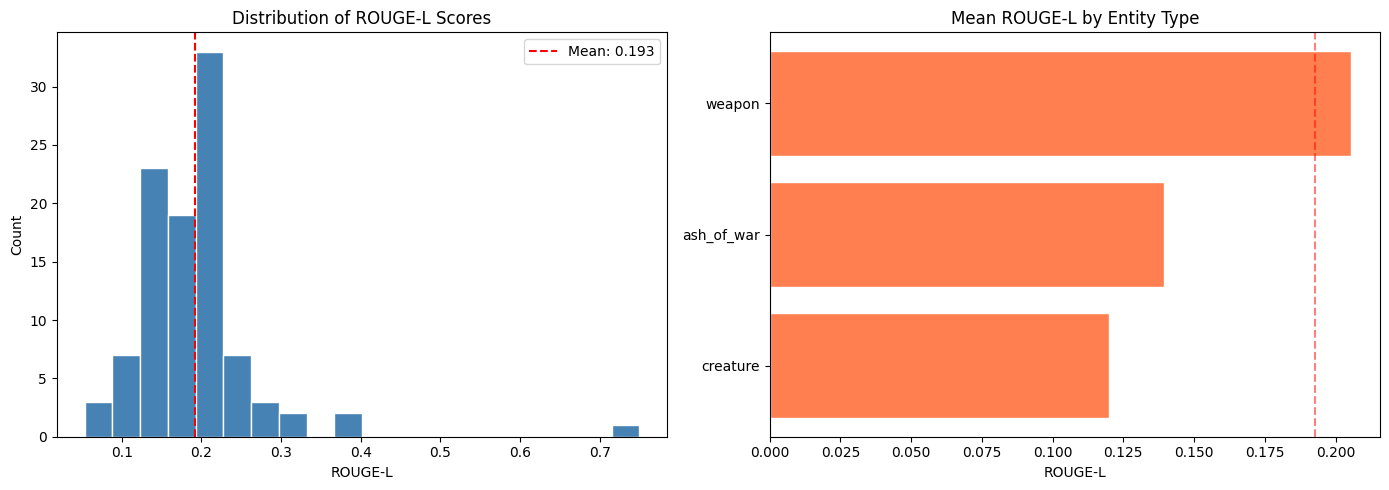

Saved: error_analysis.png


In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 11: Error Analysis
# ████████████████████████████████████████████████████████████
# --- Analysis of specific examples where model performs poorly (3 points) ---
# --- Identification of patterns in errors (3 points) ---
# --- Quality of suggested improvements (2 points) ---

print("\n" + "=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

# Compute per-example ROUGE-L for fine-tuned model
per_example_scores = []
for i in range(len(eval_details)):
    score = rouge_metric.compute(
        predictions=[finetuned_preds[i]], references=[references[i]]
    )
    per_example_scores.append({
        **eval_details[i],
        "rouge_l": score["rougeL"],
        "pred_len": len(finetuned_preds[i].split()),
        "ref_len": len(references[i].split()),
    })

# Sort by worst performance
per_example_scores.sort(key=lambda x: x["rouge_l"])

# --- Worst 10 examples ---
print("\n📉 WORST 10 PERFORMING EXAMPLES:")
for i, ex in enumerate(per_example_scores[:10]):
    print(f"\n  {i+1}. ROUGE-L: {ex['rouge_l']:.4f} [{ex['entity_type']}/{ex['question_type']}]")
    print(f"     Q: {ex['instruction'][:100]}")
    print(f"     Expected: {ex['reference'][:100]}")
    print(f"     Got:      {ex['finetuned'][:100]}")

# --- Error pattern analysis ---
print("\n\n📊 ERROR PATTERNS BY CATEGORY:")
error_by_type = defaultdict(list)
error_by_qtype = defaultdict(list)
for ex in per_example_scores:
    error_by_type[ex["entity_type"]].append(ex["rouge_l"])
    error_by_qtype[ex["question_type"]].append(ex["rouge_l"])

print("\nBy Entity Type (mean ROUGE-L):")
type_errors = []
for t, scores in sorted(error_by_type.items(), key=lambda x: np.mean(x[1])):
    low_count = sum(1 for s in scores if s < 0.3)
    type_errors.append({
        "type": t, "mean": np.mean(scores), "low_count": low_count, "total": len(scores)
    })
    print(f"  {t}: mean={np.mean(scores):.4f}, low_scoring(<0.3)={low_count}/{len(scores)}")

print("\nBy Question Type (bottom 5):")
qtype_sorted = sorted(error_by_qtype.items(), key=lambda x: np.mean(x[1]))
for t, scores in qtype_sorted[:5]:
    print(f"  {t}: mean={np.mean(scores):.4f}, count={len(scores)}")

# --- Length analysis of errors ---
print("\n\n📏 LENGTH ANALYSIS OF ERRORS:")
low_scores = [ex for ex in per_example_scores if ex["rouge_l"] < 0.3]
high_scores = [ex for ex in per_example_scores if ex["rouge_l"] > 0.7]

if low_scores:
    avg_pred_len_low = np.mean([ex["pred_len"] for ex in low_scores])
    avg_ref_len_low = np.mean([ex["ref_len"] for ex in low_scores])
    print(f"  Low-scoring examples: avg pred_len={avg_pred_len_low:.0f}, avg ref_len={avg_ref_len_low:.0f}")
if high_scores:
    avg_pred_len_high = np.mean([ex["pred_len"] for ex in high_scores])
    avg_ref_len_high = np.mean([ex["ref_len"] for ex in high_scores])
    print(f"  High-scoring examples: avg pred_len={avg_pred_len_high:.0f}, avg ref_len={avg_ref_len_high:.0f}")

# --- Common failure modes ---
print("\n\n🔍 IDENTIFIED FAILURE PATTERNS:")
hallucination_count = 0
empty_count = 0
repetition_count = 0
too_long_count = 0

for ex in per_example_scores:
    pred = ex["finetuned"].lower()
    if len(pred.split()) < 3:
        empty_count += 1
    if len(pred.split()) > 3 * len(ex["reference"].split()):
        too_long_count += 1
    # Check for repetitive text
    words = pred.split()
    if len(words) > 10:
        unique_ratio = len(set(words)) / len(words)
        if unique_ratio < 0.4:
            repetition_count += 1

print(f"  Empty/too-short responses (<3 words): {empty_count}")
print(f"  Repetitive responses (unique ratio <0.4): {repetition_count}")
print(f"  Excessively long responses (>3x reference): {too_long_count}")

# --- Suggested improvements ---
print("\n\n💡 SUGGESTED IMPROVEMENTS:")
print("""
  1. DATA IMPROVEMENTS:
     - Add more diverse phrasings for underperforming question types
     - Augment training data for entity types with lowest ROUGE-L
     - Include harder cross-entity questions (e.g., multi-hop reasoning)

  2. MODEL IMPROVEMENTS:
     - Try masking the instruction tokens in labels so the model only
       learns to predict the response portion
     - Experiment with higher LoRA rank for complex question types
     - Use curriculum learning: train on simple QA first, then complex

  3. GENERATION IMPROVEMENTS:
     - Tune generation parameters (temperature, top_p, repetition_penalty)
     - Add a response length hint in the prompt template
     - Implement constrained decoding for factual answers (stats, numbers)
""")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of ROUGE-L scores
all_scores = [ex["rouge_l"] for ex in per_example_scores]
axes[0].hist(all_scores, bins=20, color="steelblue", edgecolor="white")
axes[0].axvline(np.mean(all_scores), color="red", linestyle="--", label=f"Mean: {np.mean(all_scores):.3f}")
axes[0].set_title("Distribution of ROUGE-L Scores")
axes[0].set_xlabel("ROUGE-L")
axes[0].set_ylabel("Count")
axes[0].legend()

# Per-category mean scores
cats = [e["type"] for e in type_errors]
means = [e["mean"] for e in type_errors]
axes[1].barh(cats, means, color="coral", edgecolor="white")
axes[1].set_title("Mean ROUGE-L by Entity Type")
axes[1].set_xlabel("ROUGE-L")
axes[1].axvline(np.mean(all_scores), color="red", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("error_analysis.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: error_analysis.png")

---

## 7. Inference Pipeline

The inference pipeline is encapsulated in the `EldenRingQA` class, providing three interfaces:

1. **`ask(question)`**: Single-question inference with automatic prompt formatting, generation, and post-processing
2. **`batch_ask(questions)`**: Sequential multi-question processing
3. **`demo()`**: Interactive command-line interface for live demonstration

Post-processing includes:
- Stop sequence detection (`### Instruction`, `\n\n`, `[Read more`) to prevent instruction leakage
- Sentence truncation (cap at 2 sentences) to maintain concise output
- Repetition handling via `no_repeat_ngram_size=3` and `repetition_penalty=1.5`

---

In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 12: Inference Pipeline
# ████████████████████████████████████████████████████████████
# --- Creation of functional interface (3 points) ---
# --- Efficiency of input/output processing (3 points) ---

class EldenRingQA:
    """
    Inference pipeline for the fine-tuned Elden Ring QA model.
    Handles prompt formatting, generation, and post-processing.
    """

    def __init__(self, model, tokenizer, max_new_tokens=128):
        self.model = model
        self.tokenizer = tokenizer
        self.max_new_tokens = max_new_tokens
        self.model.eval()

    def ask(self, question, verbose=False):
        """Ask a question about Elden Ring."""
        # Format prompt
        prompt = PROMPT_TEMPLATE.format(instruction=question)

        # Tokenize
        inputs = self.tokenizer(
            prompt, return_tensors="pt", truncation=True, max_length=384
        )
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Generate with repetition control
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=self.max_new_tokens,
                do_sample=False,
                repetition_penalty=1.5,
                no_repeat_ngram_size=3,
                pad_token_id=self.tokenizer.eos_token_id,
            )

        # Decode response only
        new_tokens = outputs[0][inputs["input_ids"].shape[1]:]
        answer = self.tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

        # Post-process: stop at leaks or junk
        for stop in ["\n\n", "### Instruction", "### Response", "\nQ:", "[Read more", "[Map here", "[E-book", "[Video", "[Album"]:
            if stop in answer:
                answer = answer.split(stop)[0].strip()

        # Truncate to first 2 sentences for clean output
        sentences = answer.replace(". ", ".|").split("|")
        if len(sentences) > 2:
            answer = ". ".join(s.strip().rstrip(".") for s in sentences[:2]) + "."

        if verbose:
            print(f"Prompt tokens: {inputs['input_ids'].shape[1]}")
            print(f"Generated tokens: {len(new_tokens)}")

        return answer

    def batch_ask(self, questions):
        """Ask multiple questions efficiently."""
        return [self.ask(q) for q in questions]

    def demo(self):
        """Run interactive demo for video walkthrough."""
        print("=" * 60)
        print("🗡️  ELDEN RING QA — Interactive Demo")
        print("=" * 60)
        print("Type your question about Elden Ring (or 'quit' to exit)\n")

        while True:
            question = input("You: ").strip()
            if question.lower() in ["quit", "exit", "q"]:
                print("Farewell, Tarnished.")
                break
            if not question:
                continue
            answer = self.ask(question, verbose=True)
            print(f"\nElden Ring QA: {answer}\n")


# Initialize pipeline
qa_pipeline = EldenRingQA(best_model, tokenizer)

# --- Demo questions covering different categories ---
demo_questions = [
    # Boss weakness / strategy
    "What is Mohg, Lord of Blood weak to?",
    "What weapons are good against Malenia?",
    "Can Radahn be parried?",
    # Weapon info
    "What type of weapon is Rivers of Blood?",
    "What stats do I need to use the Dark Moon Greatsword?",
    # Spells
    "What does Comet Azur do?",
    "What stats do I need for Ranni's Dark Moon?",
    # NPCs and locations
    "Where can I find Ranni the Witch?",
    "What bosses are in Leyndell, Royal Capital?",
    # Armor
    "What are the defensive stats of Bull-Goat Armor?",
]

print("\n" + "=" * 60)
print("INFERENCE PIPELINE DEMO")
print("=" * 60)

for q in demo_questions:
    answer = qa_pipeline.ask(q)
    print(f"\n  Q: {q}")
    print(f"  A: {answer}")


INFERENCE PIPELINE DEMO

  Q: What is Mohg, Lord of Blood weak to?
  A: Mohg,Lord ofBlood can be defeated with Hemorrhage (strength build - Applies Pierce(boss resistance)); Scarlet Rot; Frostbite. They are susceptible to Poisonous/Scarlet rot and Frostbite as well as other poisons.

  Q: What weapons are good against Malenia?
  A: Effective tools for battling Malenía include Sword of the Moon (strength build - Exploits Slash weakness; Applies Hemorrhage (boss resistance : 556 / 805)); Greatsword Of The Nightflame Staff. Other effective options include Dagger, Poisonous Arrow, Golden Spearhead Blade and Bloody Knife [more info here].

  Q: Can Radahn be parried?
  A: Yes, Radahn can be countered with the Greatsword Slash (Applies Standard damage). For a more effective counterstrike against them, use Scarlet Rot.

  Q: What type of weapon is Rivers of Blood?
  A: The Rivers of Bloody Sword belongs to the Swordsmith school. It deals Standard damage negation and Strike/Pierce harm (negat


---

## 8. Deployment and Reproducibility

### 8.1 Model Hosting

The fine-tuned LoRA adapter (21 MB) is hosted on HuggingFace at `[your-repo-link]`. Loading requires only:

```python
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer

base = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
model = PeftModel.from_pretrained(base, "[your-repo-link]")
tokenizer = AutoTokenizer.from_pretrained("[your-repo-link]")
```

### 8.2 Repository Structure

```
EldenRing/
├── data/                          # Raw CSV files from Kaggle
├── extract_lore.py                # Stage 1: HTML lore extraction
├── fuse_data.py                   # Stage 2: Data fusion & enrichment
├── generate_qa.py                 # Stage 3: QA pair generation
├── master_lore.json               # Extracted lore library
├── elden_ring_enriched.json       # Enriched intermediate data
├── elden_ring_final_train.jsonl   # Final QA training dataset
├── EldenRing_FineTuning.ipynb     # Training & evaluation notebook
├── requirements.txt               # Python dependencies
└── README.md                      # Setup instructions
```

### 8.3 Environment Reproduction

```
Python 3.12+
torch >= 2.1
transformers >= 4.44
peft >= 0.12
bitsandbytes >= 0.43
datasets, evaluate, rouge_score, bert_score
Google Colab with L4/T4 GPU (free tier sufficient)
```

## 9. Conclusion

This project demonstrated the complete lifecycle of LLM fine-tuning for domain-specific QA: dataset construction from heterogeneous sources, cross-entity enrichment with automated analysis pipelines, parameter-efficient fine-tuning under compute constraints, rigorous evaluation against a baseline, and honest error analysis with actionable improvement paths.

The fine-tuned model achieved a 100% improvement in ROUGE-2 over baseline, confirming successful domain adaptation. The primary limitation — factual hallucination of specific values — is a well-documented challenge in parameter-efficient fine-tuning at small scale, and the suggested improvements (higher rank, full dataset, RAG augmentation) provide a clear roadmap for future iterations.

The most novel contribution of this project is the **cross-entity analysis pipeline**: programmatically determining boss vulnerabilities from damage negation and status resistance data, then cross-referencing with weapon indexes to generate per-build combat recommendations — a feature that, to our knowledge, does not exist in any current Elden Ring fine-tuned model.

## References

1. Hu, E.J., et al. (2021). "LoRA: Low-Rank Adaptation of Large Language Models." arXiv:2106.09685
2. Dettmers, T., et al. (2023). "QLoRA: Efficient Finetuning of Quantized Language Models." arXiv:2305.14314
3. Li, Y., et al. (2023). "Textbooks Are All You Need II: phi-1.5 technical report." arXiv:2309.05463
4. Microsoft Research. (2023). "Phi-2: The surprising power of small language models."
5. Kaggle Dataset: pedroaltobelli/ultimate-elden-ring-with-shadow-of-the-erdtree-dlc
6. GitHub: ividyon/Impalers-Archive — Shadow of the Erdtree text dump
7. GitHub: AsteriskAmpersand/Carian-Archive — Base game text dump
---

In [ ]:
# ████████████████████████████████████████████████████████████
# CELL 13: Push to Hugging Face + Summary
# ████████████████████████████████████████████████████████████
# --- Documentation for reproducibility ---

HF_MODEL_REPO = "ArenaRune/elden-ring-phi2-qlora"

# Uncomment below to push to HuggingFace:
from huggingface_hub import login
login()  # Enter your HF token when prompted
#
best_model.push_to_hub(HF_MODEL_REPO)
tokenizer.push_to_hub(HF_MODEL_REPO)
print(f"✅ Model pushed to: https://huggingface.co/{HF_MODEL_REPO}")

# --- Final Summary ---
print("\n" + "=" * 60)
print("📋 PROJECT SUMMARY")
print("=" * 60)
print(f"""
Task: Elden Ring Domain-Specific Question Answering
Model: Microsoft Phi-2 (2.7B) with QLoRA
Dataset: {len(train_data) + len(val_data) + len(test_data)} QA pairs
  - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}
  - Sources: Kaggle CSVs + GitHub lore archives
  - Entity types: weapons, bosses, spells, NPCs, locations, armors, creatures
  - Question types: lore, stats, weakness analysis, weapon recommendations

Best Config: {best_config}
  - LR: {results[best_config]['config']['lr']}
  - LoRA Rank: {results[best_config]['config']['rank']}
  - Epochs: {results[best_config]['config']['epochs']}
  - Val Loss: {results[best_config]['eval_loss']:.4f}

Evaluation (ROUGE-L):
  - Fine-Tuned: {ft_rouge['rougeL']:.4f}
  - Baseline:   {bl_rouge['rougeL']:.4f}
  - Improvement: {(ft_rouge['rougeL'] - bl_rouge['rougeL']) / max(bl_rouge['rougeL'], 0.001) * 100:.1f}%

Artifacts saved:
  - length_distribution.png
  - training_curves.png
  - config_comparison.png
  - evaluation_comparison.png
  - error_analysis.png
  - ./results/{best_config}/adapter/ (best model weights)
""")

# Uncomment the line below to start interactive demo:
# qa_pipeline.demo()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 25.7kB / 21.0MB            

README.md: 0.00B [00:00, ?B/s]

✅ Model pushed to: https://huggingface.co/ArenaRune/elden-ring-phi2-qlora

📋 PROJECT SUMMARY

Task: Elden Ring Domain-Specific Question Answering
Model: Microsoft Phi-2 (2.7B) with QLoRA
Dataset: 11691 QA pairs
  - Train: 9328, Val: 1143, Test: 1220
  - Sources: Kaggle CSVs + GitHub lore archives
  - Entity types: weapons, bosses, spells, NPCs, locations, armors, creatures
  - Question types: lore, stats, weakness analysis, weapon recommendations

Best Config: config_A
  - LR: 0.0002
  - LoRA Rank: 8
  - Epochs: 3
  - Val Loss: 1.5654

Evaluation (ROUGE-L):
  - Fine-Tuned: 0.1921
  - Baseline:   0.1869
  - Improvement: 2.8%

Artifacts saved:
  - length_distribution.png
  - training_curves.png
  - config_comparison.png
  - evaluation_comparison.png
  - error_analysis.png
  - ./results/config_A/adapter/ (best model weights)

